# UMAP Performance Analysis: By Metrics

## Research Questions

**RQ1**: What is the performance impact of individual WASM features (Distance, Tree, Matrix, NN Descent, Optimizer) compared to pure JavaScript?

**RQ2**: How does enabling all WASM features together compare to individual features and pure JavaScript?

## Methodology

- **Test Environment**: All benchmarks run on WSL2 (Windows Subsystem for Linux)
- **Baseline**: Pure JavaScript UMAP implementation (no WASM)
- **Individual Features**: Each WASM feature enabled separately (Dist, Tree, Matrix, NN, Opt)
- **All Features**: All WASM features enabled simultaneously
- **Metrics**: Runtime (ms), Memory (MB), Quality (trustworthiness), FPS, Responsiveness (ms)
- **Statistical Analysis**: Mann-Whitney U tests, bootstrap confidence intervals, effect sizes

## Notebook Structure

This notebook is organized by **metrics** to support thesis chapter writing:

1. **Setup & Data Preparation**
2. **Overview** - Quick summary of all metrics
3. **Runtime Performance & Speedup** - Execution time analysis
4. **Memory Usage** - Memory consumption patterns
5. **Embedding Quality** - Trustworthiness and accuracy
6. **Responsiveness** - FPS and interaction latency
7. **Dataset Size Effects** - How metrics scale with data size
8. **Statistical Significance** - Rigorous hypothesis testing
9. **Overall Rankings** - Composite performance scores
10. **Export Results** - Save tables and figures

## 1. Setup and Data Loading

In [29]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 3.0.0
  numpy: 2.4.2


In [30]:
# Load data
df = pd.read_csv('../outputs/preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())

Total rows: 500
Columns: 33

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
241         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
240          MNIST-like (1K points, 784D)          1000
101         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
100  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     500.000
mean      608.200
std       352.117
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64


### Data Cleaning and Preparation

In [31]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
if 'wasm_features' in df_clean.columns:
    df_clean['feature'] = df_clean['wasm_features'].fillna('none').str.lower().str.strip()
else:
    df_clean['feature'] = df_clean.get('feature', 'none')

# Map comma-separated features to 'all'
df_clean.loc[df_clean['feature'].astype(str).str.contains(',', na=False), 'feature'] = 'all'

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map).fillna(df_clean['feature'])

# Identify machine types
if 'machine_platform' in df_clean.columns:
    platform_map = {'darwin': 'MacBook', 'linux': 'Linux'}
    df_clean['machine_type'] = df_clean['machine_platform'].map(platform_map).fillna(df_clean['machine_platform'])
else:
    if 'machine_type' not in df_clean.columns:
        df_clean['machine_type'] = pd.NA

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
before = len(df_clean)
required = [c for c in ['runtime_ms', 'feature_name'] if c in df_clean.columns]
df_clean = df_clean.dropna(subset=required)
dropped = before - len(df_clean)

# Create analysis dataset
df_analysis = df_clean.copy()

# Define standard feature order
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

print(f"✓ Dataset ready: {len(df_analysis):,} measurements (dropped {dropped} rows)")
print(f"Features: {sorted(df_analysis['feature_name'].unique())}")
print(f"Datasets: {df_analysis['dataset_name'].nunique()}")
print(f"\nMeasurements per feature:")
print(df_analysis['feature_name'].value_counts().sort_index())

✓ Dataset ready: 500 measurements (dropped 0 rows)
Features: ['All Features', 'Baseline (JS)', 'Distance', 'Matrix', 'NN Descent', 'Optimizer', 'Tree']
Datasets: 6

Measurements per feature:
feature_name
All Features     100
Baseline (JS)     60
Distance          60
Matrix            60
NN Descent        60
Optimizer        100
Tree              60
Name: count, dtype: int64


## 2. Overview: All Metrics Summary

Quick overview of all performance metrics across features.

In [32]:
# Compute summary statistics for all metrics
baseline_label = 'Baseline (JS)'

# Calculate medians for each metric by feature
summary_stats = df_analysis.groupby('feature_name').agg({
    'runtime_ms': ['median', 'mean', 'std'],
    'memory_delta_mb': ['median', 'mean', 'std'],
    'trustworthiness': ['median', 'mean', 'std'],
    'fps_avg': ['median', 'mean', 'std'],
    'responsiveness_ms': ['median', 'mean', 'std']
}).round(3)

print("Summary Statistics by Feature (ordered):")
display(summary_stats.loc[feature_order])

# Calculate speedups
runtime_medians = df_analysis.groupby('feature_name')['runtime_ms'].median()
speedup_rows = []
if baseline_label in runtime_medians.index:
    baseline_rt = runtime_medians[baseline_label]
    for feat, rt in runtime_medians.drop(baseline_label).items():
        if rt > 0:
            speedup_rows.append({'feature': feat, 'speedup': baseline_rt / rt, 'improvement_%': ((baseline_rt / rt) - 1) * 100})

speedup_summary = pd.DataFrame(speedup_rows).sort_values('speedup', ascending=False)
print("\nSpeedup vs Baseline:")
display(speedup_summary.round(3))

Summary Statistics by Feature (ordered):


runtime_ms                     memory_delta_mb                 trustworthiness               fps_avg  \
                  median      mean       std          median    mean     std          median   mean    std  median   
feature_name                                                                                                         
Baseline (JS)    3512.85  3552.003   827.634          14.478  13.002   9.452           0.969  0.900  0.139  57.463   
Distance         3504.15  3610.205   871.606          12.275  11.694   9.505           0.969  0.901  0.139  57.461   
Tree             3478.60  3496.438   788.287           9.784  14.369  15.581           0.970  0.901  0.139  56.978   
Matrix           3415.65  3501.413   811.153          10.721  11.783  10.638           0.970  0.900  0.141  57.510   
NN Descent       3489.85  3603.920   844.058          16.870  17.982  11.250           0.970  0.899  0.142  57.006   
Optimizer        2357.95  2516.780  1248.133           6.294   8.424   7.699           0.967  0.883  0.167  39.660   
All Features     2237.20  2396.718  1176.987          12.668  13.215  12.102           0.967  0.884  0.165  38.262   

                              responsiveness_ms                  
                 mean     std            median    mean     std  
feature_name                                                     
Baseline (JS)  55.425   4.960            21.487  34.197  33.610  
Distance       55.151   5.428            21.530  35.152  34.678  
Tree           55.296   5.141            20.817  32.765  30.853  
Matrix         55.552   4.783            19.517  31.793  32.978  
NN Descent     55.307   5.058            20.427  34.698  35.178  
Optimizer      34.472  16.727            24.637  42.048  39.075  
All Features   33.735  17.241            20.933  36.713  35.388


Speedup vs Baseline:


,feature,speedup,improvement_%
0,All Features,1.570,57.020
4,Optimizer,1.490,48.979
2,Matrix,1.028,2.846
5,Tree,1.010,0.985
3,NN Descent,1.007,0.659
1,Distance,1.002,0.248


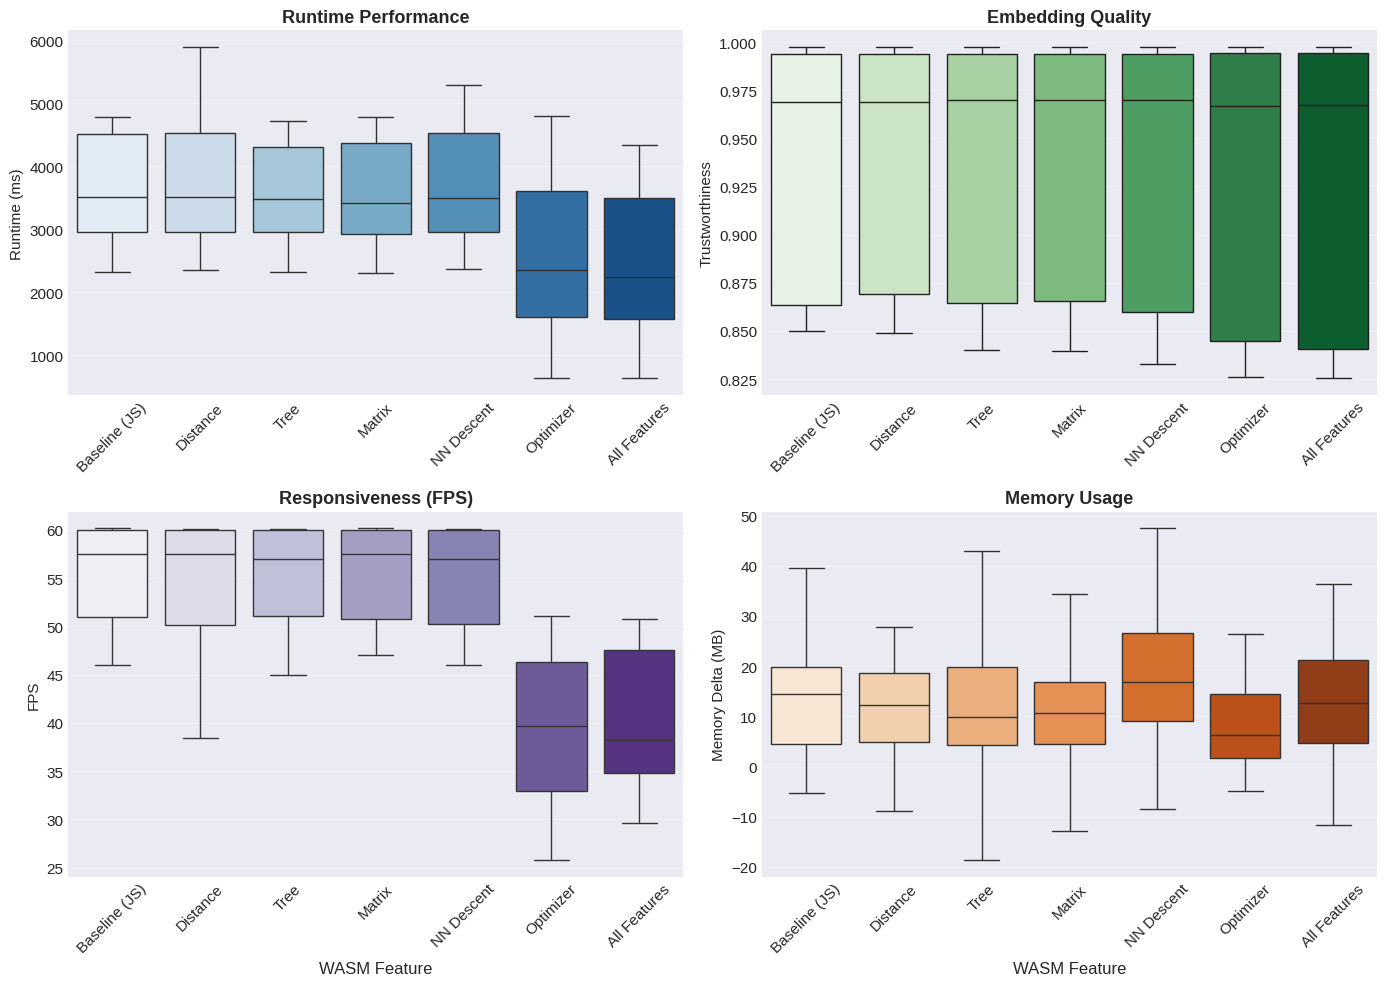

In [33]:
# Overview visualization: 4-panel metric comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Runtime
sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', order=feature_order,
            ax=axes[0, 0], showfliers=False, palette='Blues')
axes[0, 0].set_title('Runtime Performance', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Quality
if 'trustworthiness' in df_analysis:
    sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', order=feature_order,
                ax=axes[0, 1], showfliers=False, palette='Greens')
    axes[0, 1].set_title('Embedding Quality', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('Trustworthiness', fontsize=11)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)

# FPS
if 'fps_avg' in df_analysis:
    sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', order=feature_order,
                ax=axes[1, 0], showfliers=False, palette='Purples')
    axes[1, 0].set_title('Responsiveness (FPS)', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('WASM Feature', fontsize=12)
    axes[1, 0].set_ylabel('FPS', fontsize=11)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)

# Memory
if 'memory_delta_mb' in df_analysis:
    sns.boxplot(data=df_analysis, x='feature_name', y='memory_delta_mb', order=feature_order,
                ax=axes[1, 1], showfliers=False, palette='Oranges')
    axes[1, 1].set_title('Memory Usage', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('WASM Feature', fontsize=12)
    axes[1, 1].set_ylabel('Memory Delta (MB)', fontsize=11)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/overview_all_metrics.png', bbox_inches='tight', dpi=200)
plt.show()

## 3. Runtime Performance & Speedup

Detailed analysis of execution time and speedup relative to baseline.

### 3.1 Runtime Distribution by Feature

In [34]:
# Runtime statistics by feature
runtime_stats = df_analysis.groupby('feature_name')['runtime_ms'].describe()
print("Runtime Statistics (ms):")
display(runtime_stats.loc[feature_order].round(2))

# Baseline metrics
if baseline_label in df_analysis['feature_name'].values:
    baseline_rt = df_analysis[df_analysis['feature_name'] == baseline_label]['runtime_ms']
    print(f"\nBaseline (Pure JavaScript):") 
    print(f"  Median: {baseline_rt.median():.2f} ms")
    print(f"  Mean: {baseline_rt.mean():.2f} ms (±{baseline_rt.std():.2f})")
    print(f"  Range: {baseline_rt.min():.2f} - {baseline_rt.max():.2f} ms")

Runtime Statistics (ms):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,3552.00,827.63,2316.5,2959.92,3512.85,4508.85,4790.0
Distance,60.0,3610.20,871.61,2345.6,2959.25,3504.15,4533.58,5896.3
Tree,60.0,3496.44,788.29,2314.5,2956.05,3478.60,4309.85,4722.8
Matrix,60.0,3501.41,811.15,2312.3,2928.30,3415.65,4364.98,4788.4
NN Descent,60.0,3603.92,844.06,2366.2,2959.63,3489.85,4530.22,5295.8
Optimizer,100.0,2516.78,1248.13,638.1,1601.47,2357.95,3611.50,6834.9
All Features,100.0,2396.72,1176.99,629.0,1569.50,2237.20,3494.87,4342.0



Baseline (Pure JavaScript):
  Median: 3512.85 ms
  Mean: 3552.00 ms (±827.63)
  Range: 2316.50 - 4790.00 ms


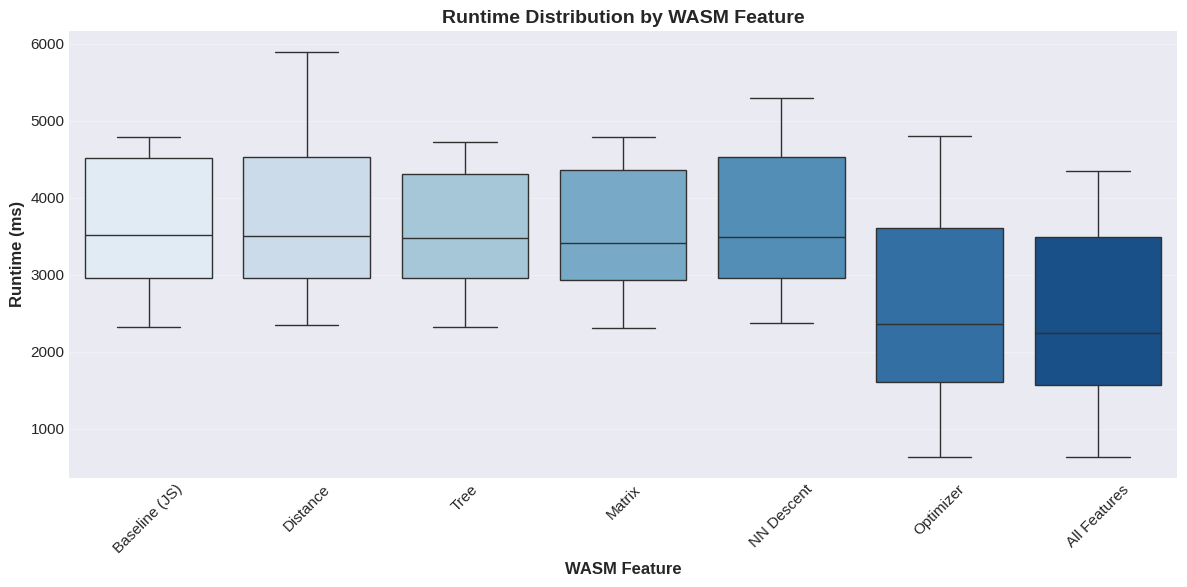

In [35]:
# Runtime distribution visualization
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', order=feature_order, 
            ax=ax, showfliers=False, palette='Blues')
ax.set_title('Runtime Distribution by WASM Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Runtime (ms)', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_distribution.png', bbox_inches='tight', dpi=200)
plt.show()

### 3.2 Speedup Analysis

In [36]:
# Calculate detailed speedup metrics
def calculate_speedup(df, baseline='Baseline (JS)'):
    results = []
    data = df
    
    for (dataset, mach), group in data.groupby(['dataset_name', 'machine_type']):
        baseline_data = group[group['feature_name'] == baseline]['runtime_ms']
        if len(baseline_data) == 0:
            continue
        baseline_median = baseline_data.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline:
                continue
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset': dataset,
                'machine': mach,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

speedup_df = calculate_speedup(df_analysis)

# Aggregate speedup statistics
speedup_summary = speedup_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std', 'min', 'max'],
    'improvement_pct': ['mean', 'median']
}).round(3)

print("Speedup Summary (vs Baseline):")
display(speedup_summary)

Speedup Summary (vs Baseline):


speedup                             improvement_pct        
                mean median    std    min    max            mean  median
feature                                                                 
All Features   2.263  1.743  1.218  1.177  4.038         126.309  74.320
Distance       0.989  0.994  0.022  0.947  1.008          -1.103  -0.556
Matrix         1.014  1.015  0.007  1.004  1.023           1.370   1.508
NN Descent     0.985  0.991  0.026  0.941  1.014          -1.455  -0.862
Optimizer      2.111  1.662  1.046  1.171  3.461         111.050  66.200
Tree           1.017  1.008  0.023  0.997  1.052           1.666   0.817

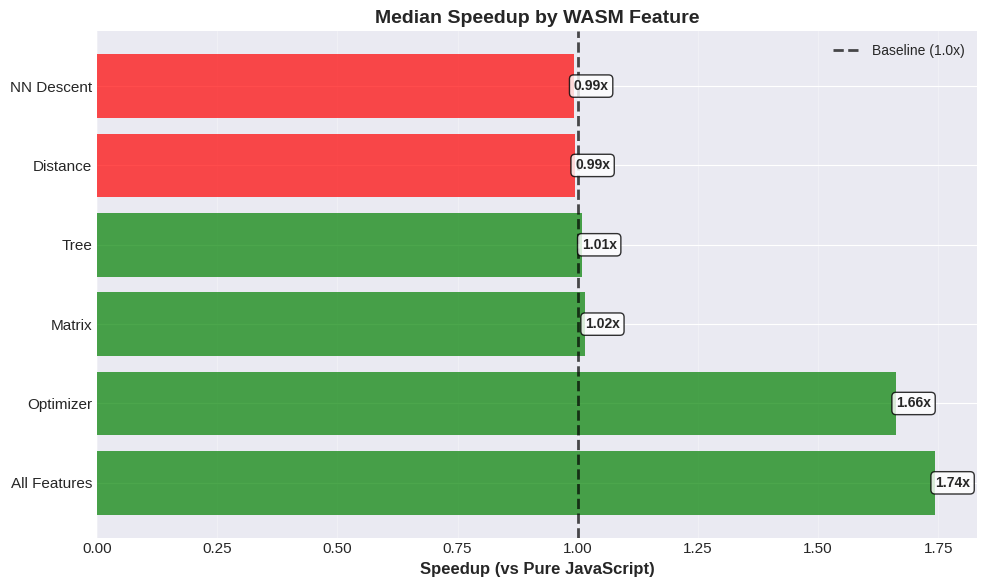


Interpretation:
  >1.0x = Faster than baseline (performance improvement)
  <1.0x = Slower than baseline (performance regression)


In [37]:
# Speedup visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate median speedup for each feature
feature_speedups = speedup_df.groupby('feature')['speedup'].median().sort_values(ascending=False)
colors = ['green' if x > 1 else 'red' for x in feature_speedups.values]

bars = ax.barh(feature_speedups.index, feature_speedups.values, color=colors, alpha=0.7)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2., f'{width:.2f}x',
           ha='left', va='center', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
ax.set_xlabel('Speedup (vs Pure JavaScript)', fontsize=12, fontweight='bold')
ax.set_title('Median Speedup by WASM Feature', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_analysis.png', bbox_inches='tight', dpi=200)
plt.show()

print("\nInterpretation:")
print("  >1.0x = Faster than baseline (performance improvement)")
print("  <1.0x = Slower than baseline (performance regression)")

## 4. Memory Usage

Analysis of memory consumption patterns across features.

In [38]:
# Memory statistics by feature
if 'memory_delta_mb' in df_analysis:
    memory_stats = df_analysis.groupby('feature_name')['memory_delta_mb'].describe()
    print("Memory Usage Statistics (MB):")
    display(memory_stats.loc[feature_order].round(2))
    
    # Baseline comparison
    if baseline_label in df_analysis['feature_name'].values:
        baseline_mem = df_analysis[df_analysis['feature_name'] == baseline_label]['memory_delta_mb']
        print(f"\nBaseline Memory Usage:")
        print(f"  Median: {baseline_mem.median():.2f} MB")
        print(f"  Mean: {baseline_mem.mean():.2f} MB (±{baseline_mem.std():.2f})")

Memory Usage Statistics (MB):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,13.00,9.45,-5.31,4.52,14.48,19.83,39.47
Distance,60.0,11.69,9.50,-8.78,4.83,12.28,18.71,42.08
Tree,60.0,14.37,15.58,-18.60,4.21,9.78,19.78,60.22
Matrix,60.0,11.78,10.64,-17.46,4.50,10.72,16.82,40.21
NN Descent,60.0,17.98,11.25,-8.42,9.03,16.87,26.68,47.45
Optimizer,100.0,8.42,7.70,-4.81,1.80,6.29,14.49,26.41
All Features,100.0,13.22,12.10,-11.73,4.63,12.67,21.13,36.28



Baseline Memory Usage:
  Median: 14.48 MB
  Mean: 13.00 MB (±9.45)


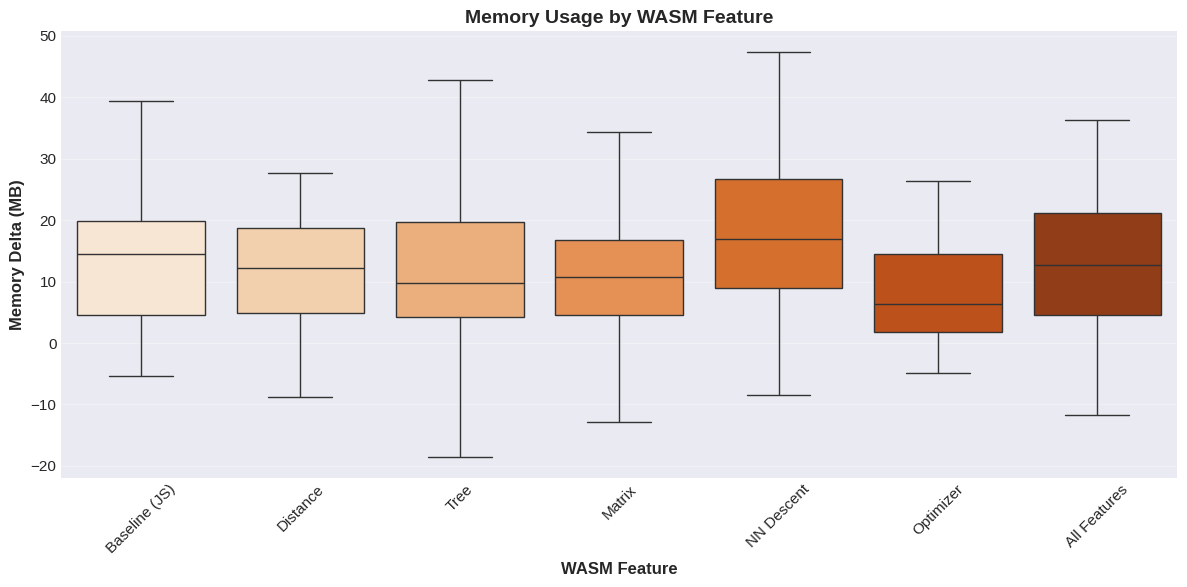

In [39]:
# Memory usage visualization
if 'memory_delta_mb' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='memory_delta_mb', order=feature_order,
                ax=ax, showfliers=False, palette='Oranges')
    ax.set_title('Memory Usage by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory Delta (MB)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/memory_usage.png', bbox_inches='tight', dpi=200)
    plt.show()

## 5. Embedding Quality (Trustworthiness)

Analysis of UMAP embedding quality across features.

In [40]:
# Quality statistics by feature
if 'trustworthiness' in df_analysis:
    quality_stats = df_analysis.groupby('feature_name')['trustworthiness'].describe()
    print("Embedding Quality (Trustworthiness):")
    display(quality_stats.loc[feature_order].round(4))
    
    # Check if quality is preserved
    baseline_quality = df_analysis[df_analysis['feature_name'] == baseline_label]['trustworthiness'].median()
    print(f"\nBaseline Quality: {baseline_quality:.4f}")
    
    for feat in feature_order:
        if feat == baseline_label:
            continue
        feat_quality = df_analysis[df_analysis['feature_name'] == feat]['trustworthiness'].median()
        diff = feat_quality - baseline_quality
        pct_diff = (diff / baseline_quality) * 100
        status = "✓" if abs(pct_diff) < 1 else ("↑" if diff > 0 else "↓")
        print(f"  {feat}: {feat_quality:.4f} ({pct_diff:+.2f}%) {status}")

Embedding Quality (Trustworthiness):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,0.900,0.139,0.601,0.863,0.969,0.994,0.998
Distance,60.0,0.901,0.139,0.602,0.869,0.969,0.994,0.997
Tree,60.0,0.901,0.139,0.606,0.865,0.970,0.994,0.997
Matrix,60.0,0.900,0.141,0.601,0.865,0.970,0.994,0.997
NN Descent,60.0,0.899,0.142,0.599,0.860,0.970,0.994,0.997
Optimizer,100.0,0.883,0.167,0.553,0.845,0.967,0.994,0.997
All Features,100.0,0.884,0.165,0.562,0.840,0.968,0.994,0.997



Baseline Quality: 0.9688
  Distance: 0.9691 (+0.03%) ✓
  Tree: 0.9701 (+0.14%) ✓
  Matrix: 0.9696 (+0.09%) ✓
  NN Descent: 0.9698 (+0.11%) ✓
  Optimizer: 0.9666 (-0.22%) ✓
  All Features: 0.9675 (-0.13%) ✓


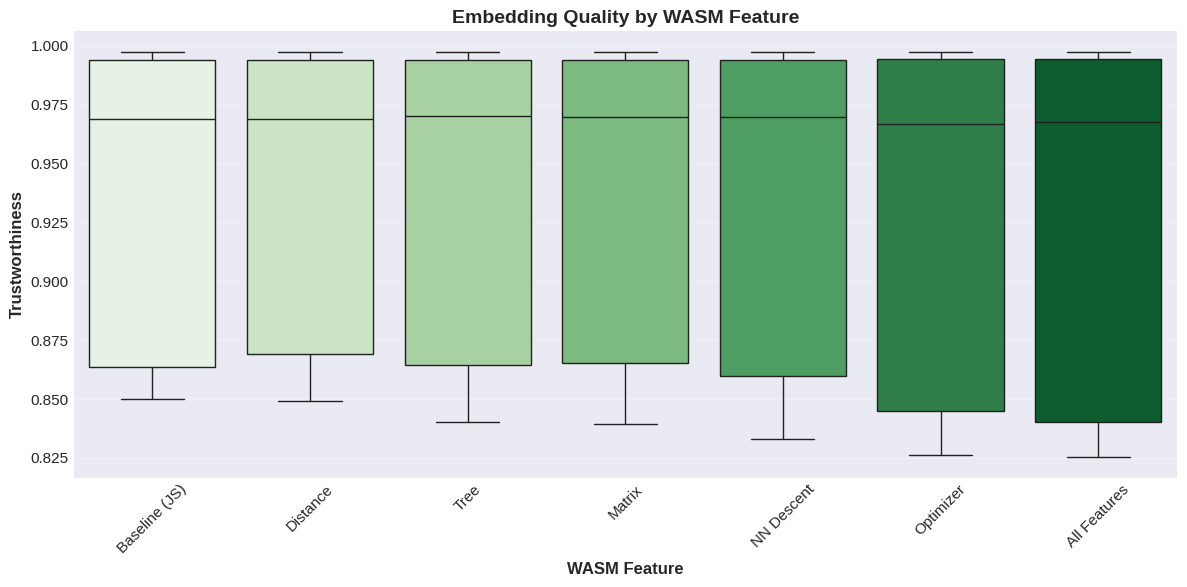

In [41]:
# Quality distribution visualization
if 'trustworthiness' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', order=feature_order,
                ax=ax, showfliers=False, palette='Greens')
    ax.set_title('Embedding Quality by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trustworthiness', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/quality_analysis.png', bbox_inches='tight', dpi=200)
    plt.show()

### Quality vs Performance Trade-off

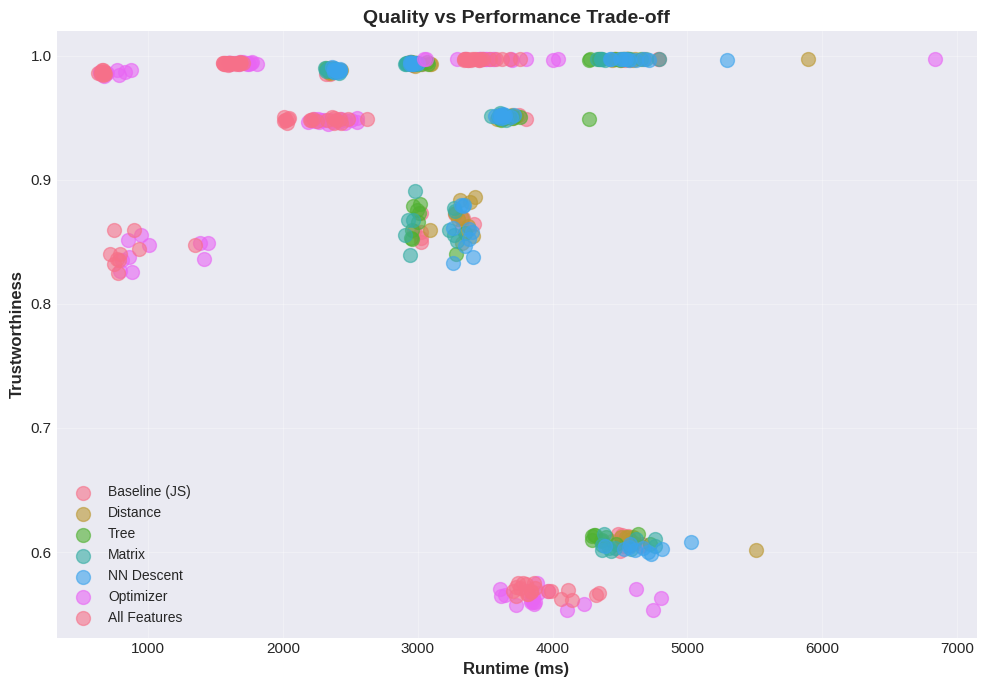

Interpretation: Points closer to the bottom-right indicate better performance with maintained quality.


In [42]:
# Quality vs runtime scatter plot
if 'trustworthiness' in df_analysis:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    for feature in feature_order:
        feature_data = df_analysis[df_analysis['feature_name'] == feature]
        ax.scatter(feature_data['runtime_ms'], feature_data['trustworthiness'],
                  label=feature, alpha=0.6, s=100)
    
    ax.set_xlabel('Runtime (ms)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trustworthiness', fontsize=12, fontweight='bold')
    ax.set_title('Quality vs Performance Trade-off', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best', framealpha=0.9)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/quality_vs_performance.png', bbox_inches='tight', dpi=200)
    plt.show()
    
    print("Interpretation: Points closer to the bottom-right indicate better performance with maintained quality.")

## 6. Responsiveness: FPS & Interaction Latency

Analysis of user-facing performance metrics.

### 6.1 Frames Per Second (FPS)

In [43]:
# FPS statistics by feature
if 'fps_avg' in df_analysis:
    fps_stats = df_analysis.groupby('feature_name')['fps_avg'].describe()
    print("FPS Statistics:")
    display(fps_stats.loc[feature_order].round(2))
    
    # Baseline comparison
    baseline_fps = df_analysis[df_analysis['feature_name'] == baseline_label]['fps_avg'].median()
    print(f"\nBaseline FPS: {baseline_fps:.2f}")
    
    for feat in feature_order:
        if feat == baseline_label:
            continue
        feat_fps = df_analysis[df_analysis['feature_name'] == feat]['fps_avg'].median()
        diff = feat_fps - baseline_fps
        pct_diff = (diff / baseline_fps) * 100
        print(f"  {feat}: {feat_fps:.2f} FPS ({pct_diff:+.2f}%)")

FPS Statistics:


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,55.43,4.96,45.99,51.00,57.46,60.00,60.14
Distance,60.0,55.15,5.43,38.43,50.15,57.46,60.00,60.13
Tree,60.0,55.30,5.14,44.99,51.05,56.98,60.00,60.13
Matrix,60.0,55.55,4.78,47.00,50.75,57.51,59.99,60.15
NN Descent,60.0,55.31,5.06,45.99,50.24,57.01,59.99,60.13
Optimizer,100.0,34.47,16.73,0.00,32.95,39.66,46.34,51.09
All Features,100.0,33.73,17.24,0.00,34.81,38.26,47.58,50.76



Baseline FPS: 57.46
  Distance: 57.46 FPS (-0.00%)
  Tree: 56.98 FPS (-0.84%)
  Matrix: 57.51 FPS (+0.08%)
  NN Descent: 57.01 FPS (-0.80%)
  Optimizer: 39.66 FPS (-30.98%)
  All Features: 38.26 FPS (-33.41%)


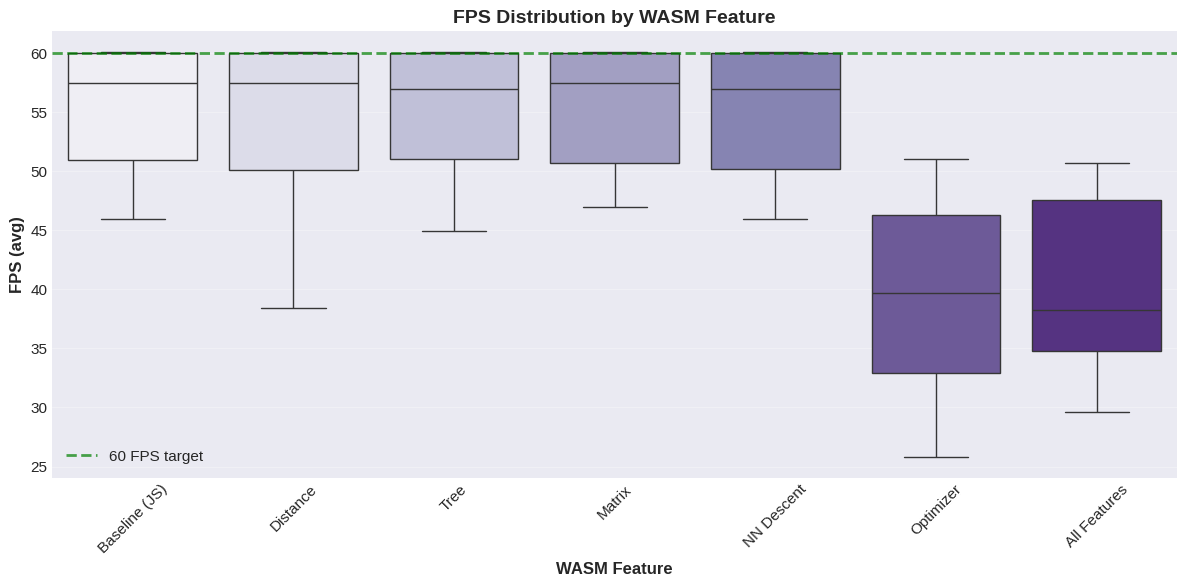

In [44]:
# FPS visualization
if 'fps_avg' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', order=feature_order,
                ax=ax, showfliers=False, palette='Purples')
    ax.set_title('FPS Distribution by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('FPS (avg)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # Add 60 FPS reference line
    ax.axhline(y=60, color='green', linestyle='--', linewidth=2, alpha=0.7, label='60 FPS target')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/fps_analysis.png', bbox_inches='tight', dpi=200)
    plt.show()

### 6.2 Interaction Latency (Responsiveness)

In [45]:
# Responsiveness statistics by feature
if 'responsiveness_ms' in df_analysis:
    resp_stats = df_analysis.groupby('feature_name')['responsiveness_ms'].describe()
    print("Responsiveness Statistics (ms):")
    display(resp_stats.loc[feature_order].round(2))
    
    # Baseline comparison
    baseline_resp = df_analysis[df_analysis['feature_name'] == baseline_label]['responsiveness_ms'].median()
    print(f"\nBaseline Responsiveness: {baseline_resp:.2f} ms")
    
    for feat in feature_order:
        if feat == baseline_label:
            continue
        feat_resp = df_analysis[df_analysis['feature_name'] == feat]['responsiveness_ms'].median()
        diff = feat_resp - baseline_resp
        pct_diff = (diff / baseline_resp) * 100
        status = "✓" if diff < 0 else "↑"
        print(f"  {feat}: {feat_resp:.2f} ms ({pct_diff:+.2f}%) {status}")
    
    print("\nNote: Lower responsiveness = Better (less latency)")

Responsiveness Statistics (ms):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,34.20,33.61,0.00,17.39,21.49,28.97,116.88
Distance,60.0,35.15,34.68,7.77,18.16,21.53,30.07,130.15
Tree,60.0,32.76,30.85,0.00,17.53,20.82,29.72,104.05
Matrix,60.0,31.79,32.98,0.00,15.56,19.52,27.12,111.88
NN Descent,60.0,34.70,35.18,8.14,16.90,20.43,28.10,121.46
Optimizer,100.0,42.05,39.07,9.09,19.27,24.64,34.21,143.05
All Features,100.0,36.71,35.39,9.12,15.92,20.93,27.68,128.20



Baseline Responsiveness: 21.49 ms
  Distance: 21.53 ms (+0.20%) ↑
  Tree: 20.82 ms (-3.12%) ✓
  Matrix: 19.52 ms (-9.17%) ✓
  NN Descent: 20.43 ms (-4.93%) ✓
  Optimizer: 24.64 ms (+14.66%) ↑
  All Features: 20.93 ms (-2.58%) ✓

Note: Lower responsiveness = Better (less latency)


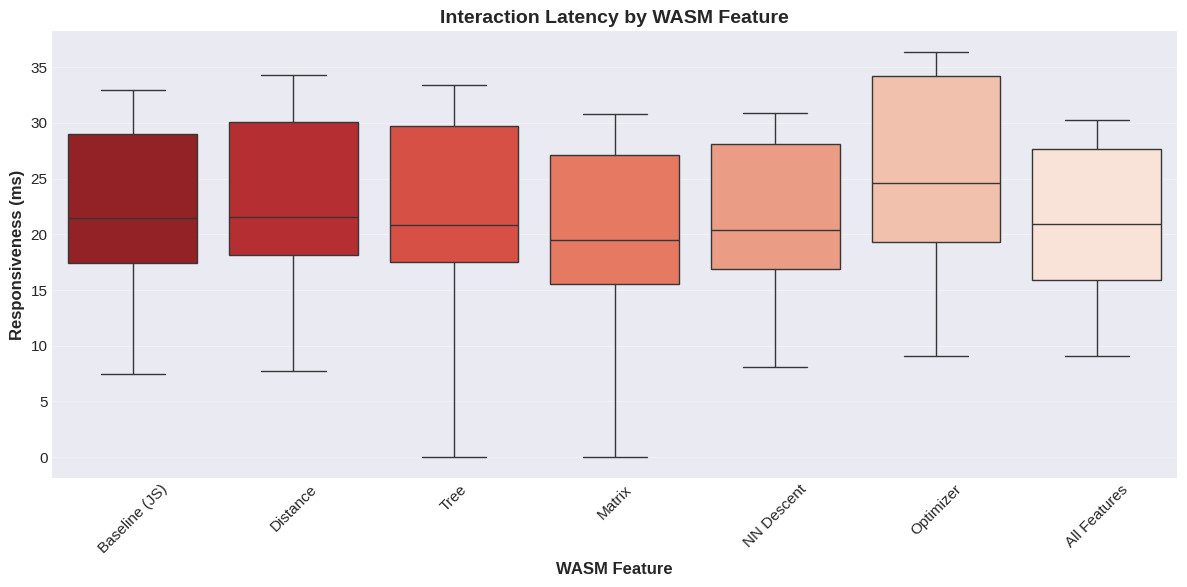

In [46]:
# Responsiveness visualization
if 'responsiveness_ms' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='responsiveness_ms', order=feature_order,
                ax=ax, showfliers=False, palette='Reds_r')
    ax.set_title('Interaction Latency by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Responsiveness (ms)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/responsiveness_analysis.png', bbox_inches='tight', dpi=200)
    plt.show()

## 7. Dataset Size Effects

How each metric scales with dataset size.

In [47]:
# Prepare dataset size analysis
df_analysis['dataset_size'] = pd.to_numeric(df_analysis['dataset_size'], errors='coerce')

# Create size categories
df_analysis['size_category'] = pd.cut(
    df_analysis['dataset_size'],
    bins=[0, 200, 800, float('inf')],
    labels=['Small (≤200)', 'Medium (200-800)', 'Large (>800)']
)

print("Dataset Size Distribution:")
print(df_analysis.groupby('dataset_name')['dataset_size'].first().sort_values())
print(f"\nSize category counts:")
print(df_analysis['size_category'].value_counts().sort_index())

Dataset Size Distribution:
dataset_name
Small Random (80 points)                  80
Iris Dataset (150 points, 4D)            150
Swiss Roll (600 points, 3D manifold)     600
Medium Clustered (600 points)            600
MNIST-like (1K points, 784D)            1000
3D Dense Clusters (1K points)           1000
Name: dataset_size, dtype: int64

Size category counts:
size_category
Small (≤200)        140
Medium (200-800)    180
Large (>800)        180
Name: count, dtype: int64


### Runtime Scaling

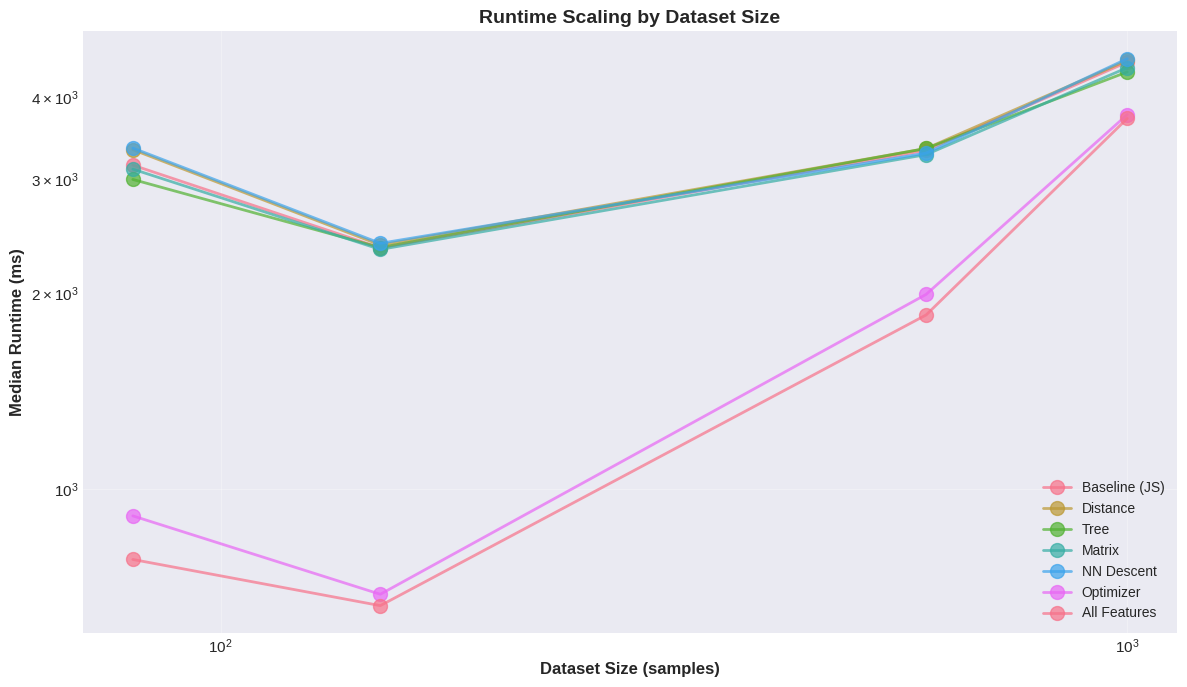

In [48]:
# Runtime scaling with dataset size
fig, ax = plt.subplots(figsize=(12, 7))

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
    ax.plot(size_runtime.index, size_runtime.values, marker='o', label=feature, 
           linewidth=2, markersize=10, alpha=0.7)

ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Runtime (ms)', fontsize=12, fontweight='bold')
ax.set_title('Runtime Scaling by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_scaling.png', bbox_inches='tight', dpi=200)
plt.show()

### Speedup by Dataset Size

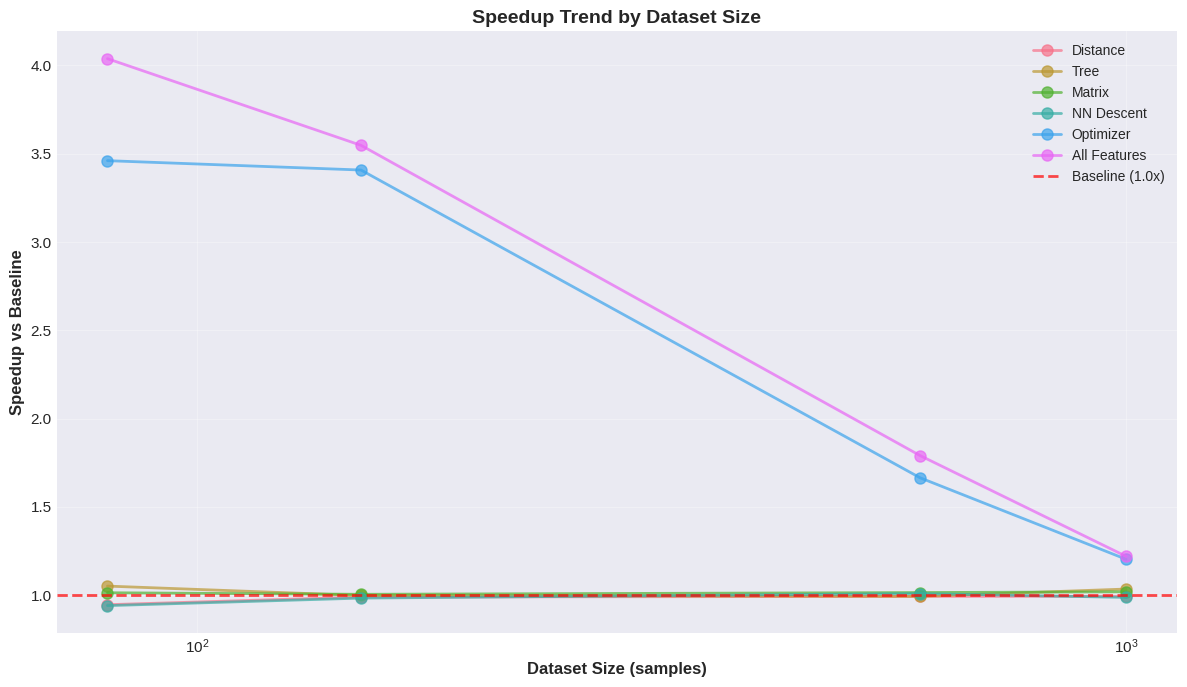

In [49]:
# Calculate speedup by size
def calculate_speedup_by_size(df, baseline='Baseline (JS)'):
    results = []
    for (size, machine), group in df.groupby(['dataset_size', 'machine_type']):
        baseline_data = group[group['feature_name'] == baseline]['runtime_ms']
        if len(baseline_data) == 0:
            continue
        baseline_median = baseline_data.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline:
                continue
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset_size': size,
                'feature': feature,
                'speedup': speedup
            })
    return pd.DataFrame(results)

speedup_by_size = calculate_speedup_by_size(df_analysis)

# Visualize speedup trends
fig, ax = plt.subplots(figsize=(12, 7))

for feature in speedup_by_size['feature'].unique():
    feat_data = speedup_by_size[speedup_by_size['feature'] == feature].sort_values('dataset_size')
    if len(feat_data) == 0:
        continue
    ax.plot(feat_data['dataset_size'], feat_data['speedup'], 
           marker='o', label=feature, linewidth=2, markersize=8, alpha=0.7)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (1.0x)')
ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup vs Baseline', fontsize=12, fontweight='bold')
ax.set_title('Speedup Trend by Dataset Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_by_size.png', bbox_inches='tight', dpi=200)
plt.show()

## 8. Statistical Significance Testing

Rigorous statistical tests comparing each feature to baseline.

In [50]:
# Mann-Whitney U test
def mann_whitney_test(df, baseline='Baseline (JS)'):
    results = []
    baseline_data = df[df['feature_name'] == baseline]['runtime_ms'].dropna()
    
    if len(baseline_data) < 3:
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna()
        if len(feature_data) < 3:
            continue
        
        # Mann-Whitney U test
        statistic, p_value = mannwhitneyu(baseline_data, feature_data, alternative='two-sided')
        
        # Cliff's Delta (effect size)
        n1, n2 = len(baseline_data), len(feature_data)
        pairs_greater = sum(1 for b in baseline_data for f in feature_data if b > f)
        pairs_less = sum(1 for b in baseline_data for f in feature_data if b < f)
        cliffs_delta = (pairs_greater - pairs_less) / (n1 * n2)
        
        # Effect size interpretation
        abs_delta = abs(cliffs_delta)
        if abs_delta < 0.147:
            effect_size = 'negligible'
        elif abs_delta < 0.33:
            effect_size = 'small'
        elif abs_delta < 0.474:
            effect_size = 'medium'
        else:
            effect_size = 'large'
        
        results.append({
            'feature': feature,
            'n_baseline': len(baseline_data),
            'n_feature': len(feature_data),
            'baseline_median': baseline_data.median(),
            'feature_median': feature_data.median(),
            'p_value': p_value,
            'significant': p_value < 0.05,
            'cliffs_delta': cliffs_delta,
            'effect_size': effect_size
        })
    
    return pd.DataFrame(results)

test_results = mann_whitney_test(df_analysis)

print("Statistical Test Results (Mann-Whitney U Test):")
print("\nSignificance: p < 0.05")
print("Cliff's Delta: negative = feature is faster\n")
display(test_results.round(4))

Statistical Test Results (Mann-Whitney U Test):

Significance: p < 0.05
Cliff's Delta: negative = feature is faster



,feature,n_baseline,n_feature,baseline_median,feature_median,p_value,significant,cliffs_delta,effect_size
0,Distance,60,60,3512.85,3504.15,0.700,False,-0.041,negligible
1,Tree,60,60,3512.85,3478.60,0.439,False,0.082,negligible
2,Matrix,60,60,3512.85,3415.65,0.305,False,0.109,negligible
3,NN Descent,60,60,3512.85,3489.85,0.598,False,-0.056,negligible
4,All Features,60,100,3512.85,2237.20,0.000,True,0.510,large
5,Optimizer,60,100,3512.85,2357.95,0.000,True,0.472,medium


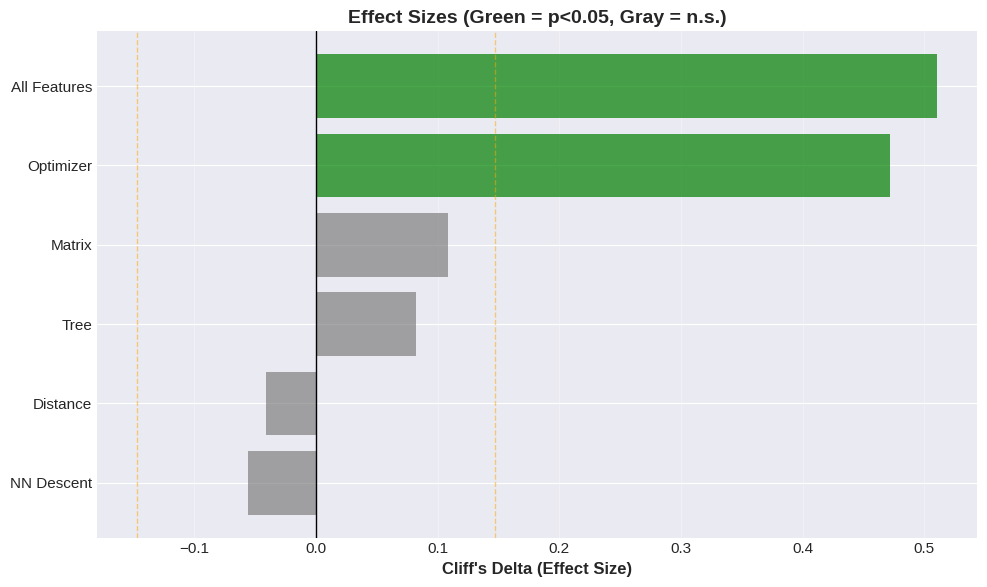

Negative = feature faster than baseline
Positive = feature slower than baseline


In [51]:
# Visualize effect sizes
if len(test_results) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    test_results_sorted = test_results.sort_values('cliffs_delta')
    colors = ['green' if sig else 'gray' for sig in test_results_sorted['significant']]
    
    ax.barh(test_results_sorted['feature'], test_results_sorted['cliffs_delta'], 
           color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax.axvline(x=-0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax.axvline(x=0.147, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel("Cliff's Delta (Effect Size)", fontsize=12, fontweight='bold')
    ax.set_title('Effect Sizes (Green = p<0.05, Gray = n.s.)', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/statistical_significance.png', bbox_inches='tight', dpi=200)
    plt.show()
    
    print("Negative = feature faster than baseline")
    print("Positive = feature slower than baseline")

### Bootstrap Confidence Intervals

In [52]:
# Bootstrap CI for speedup
def bootstrap_speedup_ci(df, baseline='Baseline (JS)', n_bootstrap=10000, confidence=0.95):
    results = []
    rng = np.random.default_rng(42)
    baseline_data = df[df['feature_name'] == baseline]['runtime_ms'].dropna().values
    
    if len(baseline_data) < 3:
        return pd.DataFrame()
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        feature_data = df[df['feature_name'] == feature]['runtime_ms'].dropna().values
        if len(feature_data) < 3:
            continue
        
        speedups = []
        for _ in range(n_bootstrap):
            base_sample = rng.choice(baseline_data, size=len(baseline_data), replace=True)
            feat_sample = rng.choice(feature_data, size=len(feature_data), replace=True)
            speedup = np.median(base_sample) / np.median(feat_sample)
            speedups.append(speedup)
        
        speedups = np.array(speedups)
        alpha = 1 - confidence
        ci_lower = np.percentile(speedups, alpha/2 * 100)
        ci_upper = np.percentile(speedups, (1 - alpha/2) * 100)
        
        results.append({
            'feature': feature,
            'speedup_median': np.median(speedups),
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower
        })
    
    return pd.DataFrame(results)

print("Calculating bootstrap confidence intervals (10,000 iterations)...")
bootstrap_results = bootstrap_speedup_ci(df_analysis)

print("\n95% Confidence Intervals for Speedup:")
display(bootstrap_results.round(3))

Calculating bootstrap confidence intervals (10,000 iterations)...

95% Confidence Intervals for Speedup:


,feature,speedup_median,ci_lower,ci_upper,ci_width
0,Distance,0.997,0.834,1.108,0.273
1,Tree,1.009,0.834,1.216,0.382
2,Matrix,1.016,0.842,1.221,0.379
3,NN Descent,1.001,0.839,1.101,0.263
4,All Features,1.544,1.213,1.860,0.647
5,Optimizer,1.484,1.221,1.782,0.561


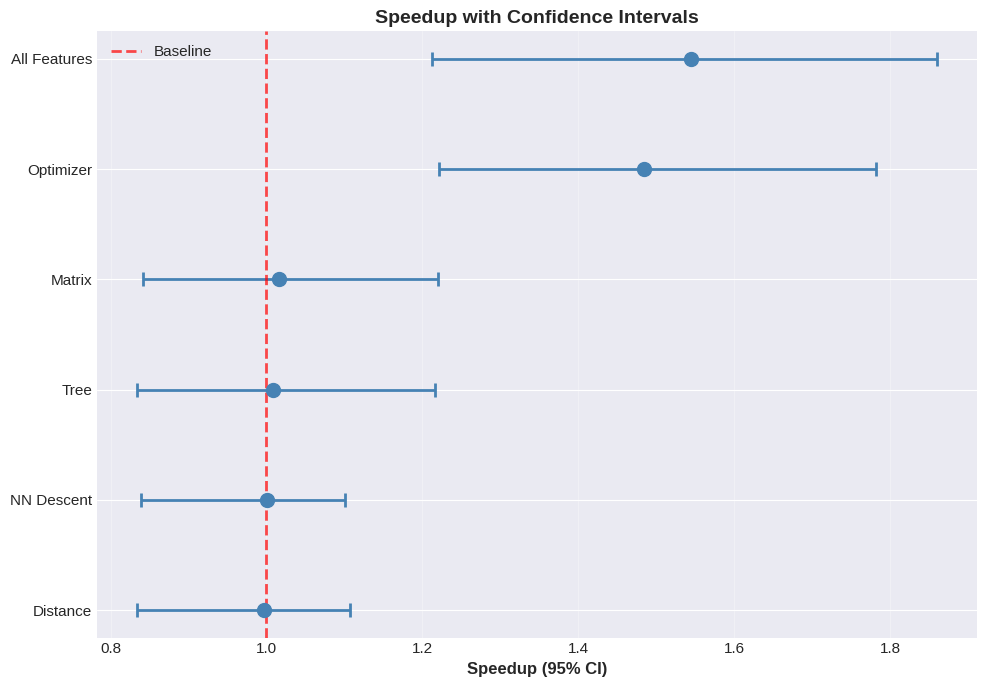

In [53]:
# Visualize confidence intervals
if len(bootstrap_results) > 0:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    bootstrap_results_sorted = bootstrap_results.sort_values('speedup_median')
    y_pos = np.arange(len(bootstrap_results_sorted))
    
    ax.errorbar(
        bootstrap_results_sorted['speedup_median'],
        y_pos,
        xerr=[
            bootstrap_results_sorted['speedup_median'] - bootstrap_results_sorted['ci_lower'],
            bootstrap_results_sorted['ci_upper'] - bootstrap_results_sorted['speedup_median']
        ],
        fmt='o', markersize=10, capsize=5, capthick=2, elinewidth=2, color='steelblue'
    )
    
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(bootstrap_results_sorted['feature'])
    ax.set_xlabel('Speedup (95% CI)', fontsize=12, fontweight='bold')
    ax.set_title('Speedup with Confidence Intervals', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/bootstrap_confidence_intervals.png', bbox_inches='tight', dpi=200)
    plt.show()

## 9. Overall Rankings: Composite Performance Scores

Rank features using a weighted composite score across all metrics.

In [54]:
# Calculate composite performance scores
def calculate_composite_scores(df, baseline='Baseline (JS)'):
    results = []
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        
        feature_data = df[df['feature_name'] == feature]
        baseline_data = df[df['feature_name'] == baseline]
        
        # Runtime speedup
        speedup = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
        
        # Quality ratio
        quality_ratio = feature_data['trustworthiness'].median() / baseline_data['trustworthiness'].median() if 'trustworthiness' in df else 1.0
        
        # FPS ratio
        fps_ratio = feature_data['fps_avg'].median() / baseline_data['fps_avg'].median() if 'fps_avg' in df else 1.0
        
        # Memory impact (lower is better, normalize to 0-1 scale)
        memory_delta = feature_data['memory_delta_mb'].median() if 'memory_delta_mb' in df else 0
        memory_score = max(0, 1 - abs(memory_delta) / 100)  # Normalize
        
        # Composite score: weighted average
        # Weights: 50% speedup, 25% quality, 15% FPS, 10% memory
        composite = (0.50 * speedup + 0.25 * quality_ratio + 0.15 * fps_ratio + 0.10 * memory_score)
        
        results.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'memory_score': memory_score,
            'composite_score': composite
        })
    
    return pd.DataFrame(results).sort_values('composite_score', ascending=False)

rankings = calculate_composite_scores(df_analysis)

print("Overall Performance Rankings:")
print("="*80)
display(rankings.round(3))

print("\nTop 3 Features:")
for i, (idx, row) in enumerate(rankings.head(3).iterrows(), 1):
    print(f"{i}. {row['feature']} (score: {row['composite_score']:.3f})")
    print(f"   - Speedup: {row['speedup']:.2f}x")
    print(f"   - Quality ratio: {row['quality_ratio']:.3f}")
    print(f"   - FPS ratio: {row['fps_ratio']:.3f}")

Overall Performance Rankings:


,feature,speedup,quality_ratio,fps_ratio,memory_score,composite_score
4,All Features,1.570,0.999,0.666,0.873,1.222
5,Optimizer,1.490,0.998,0.690,0.937,1.192
2,Matrix,1.028,1.001,1.001,0.893,1.004
1,Tree,1.010,1.001,0.992,0.902,0.994
0,Distance,1.002,1.000,1.000,0.877,0.989
3,NN Descent,1.007,1.001,0.992,0.831,0.986



Top 3 Features:
1. All Features (score: 1.222)
   - Speedup: 1.57x
   - Quality ratio: 0.999
   - FPS ratio: 0.666
2. Optimizer (score: 1.192)
   - Speedup: 1.49x
   - Quality ratio: 0.998
   - FPS ratio: 0.690
3. Matrix (score: 1.004)
   - Speedup: 1.03x
   - Quality ratio: 1.001
   - FPS ratio: 1.001


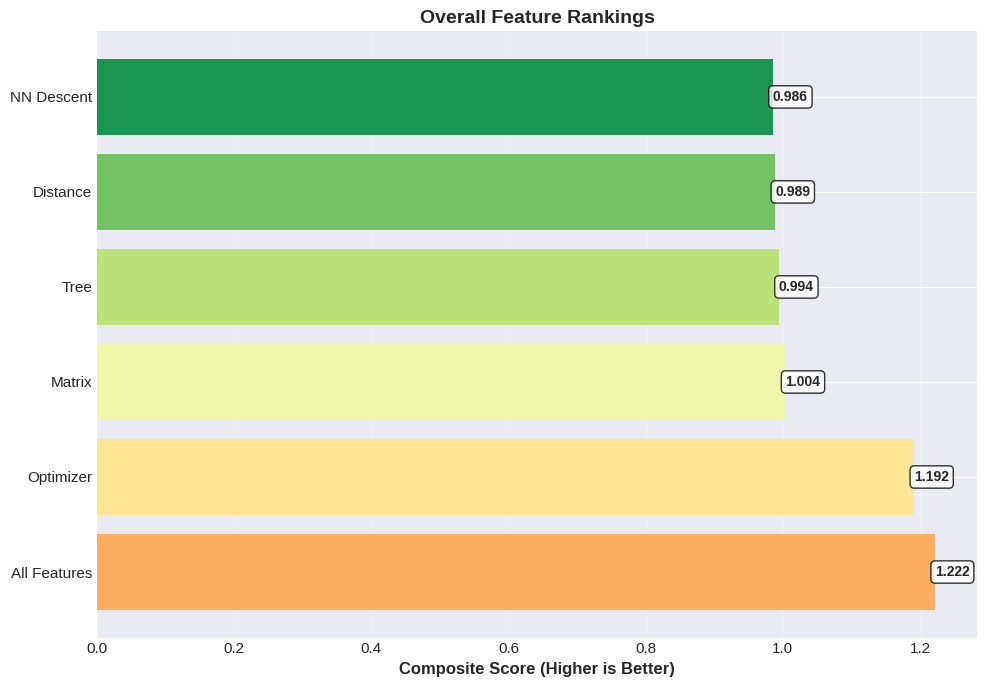

In [55]:
# Rankings visualization
if len(rankings) > 0:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rankings)))
    bars = ax.barh(rankings['feature'], rankings['composite_score'], color=colors)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2., f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Composite Score (Higher is Better)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Feature Rankings', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/overall_rankings.png', bbox_inches='tight', dpi=200)
    plt.show()

## 10. Export Results

Save all analysis results to CSV files for thesis inclusion.

In [56]:
# Create summaries directory if it doesn't exist
import os
os.makedirs('../outputs/summaries', exist_ok=True)

# Export summary tables
if len(speedup_df) > 0:
    speedup_df.to_csv('../outputs/summaries/speedup_analysis.csv', index=False)
    print("✓ Saved speedup_analysis.csv")

if len(test_results) > 0:
    test_results.to_csv('../outputs/summaries/statistical_tests.csv', index=False)
    print("✓ Saved statistical_tests.csv")

if len(bootstrap_results) > 0:
    bootstrap_results.to_csv('../outputs/summaries/bootstrap_confidence_intervals.csv', index=False)
    print("✓ Saved bootstrap_confidence_intervals.csv")

if len(rankings) > 0:
    rankings.to_csv('../outputs/summaries/feature_rankings.csv', index=False)
    print("✓ Saved feature_rankings.csv")

# Export metric-specific summaries
summary_stats.to_csv('../outputs/summaries/metrics_summary.csv')
print("✓ Saved metrics_summary.csv")

print("\n" + "="*80)
print("All analysis results exported to ../outputs/summaries/")
print("All figures saved to ../outputs/figures/")
print("="*80)

✓ Saved speedup_analysis.csv
✓ Saved statistical_tests.csv
✓ Saved bootstrap_confidence_intervals.csv
✓ Saved feature_rankings.csv
✓ Saved metrics_summary.csv

All analysis results exported to ../outputs/summaries/
All figures saved to ../outputs/figures/


## Summary

This notebook analyzed UMAP performance across multiple metrics:

1. **Runtime & Speedup**: Execution time and performance gains
2. **Memory Usage**: Memory consumption patterns
3. **Embedding Quality**: Trustworthiness preservation
4. **Responsiveness**: FPS and interaction latency
5. **Dataset Size Effects**: Scaling behavior
6. **Statistical Significance**: Rigorous hypothesis testing
7. **Overall Rankings**: Composite performance scores